In [1]:
import requests
import zipfile
import pandas as pd
from io import BytesIO

url = 'https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-nyc-car-accident-severity/blob/main/data/processed/Processed_Data_v2.zip?raw=true'

# Download the zip file
response = requests.get(url)
zip_content = BytesIO(response.content)

# Unzip the file
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    # Extract all the contents into the current directory
    zip_ref.extractall()

    csv_filename = zip_ref.namelist()[0]

    # Read the CSV file
    mvc_processed = pd.read_csv(csv_filename)

In [2]:
# Combine Class 1, 2, 3 to make a  binary class dataset

mvc_processed_binary = mvc_processed

# Display original class distribution
print("Original Class Distribution:")
print(mvc_processed_binary['CLASS TYPE'].value_counts())

# Function to combine classes
def combine_classes(label):
    if label == 'Class 0':
        return 'Class 0'
    else:
        return 'Class 1'

# Apply the function to the 'CLASS TYPE' column
mvc_processed_binary['CLASS TYPE'] = mvc_processed_binary['CLASS TYPE'].apply(combine_classes)

# Display new class distribution
print("\nNew Class Distribution:")
print(mvc_processed_binary['CLASS TYPE'].value_counts())

Original Class Distribution:
CLASS TYPE
Class 0    824193
Class 1    231289
Class 2      1030
Class 3       905
Name: count, dtype: int64

New Class Distribution:
CLASS TYPE
Class 0    824193
Class 1    233224
Name: count, dtype: int64


In [3]:
# Convert CRASH DATE and CRASH TIME to datetime
mvc_processed_binary['CRASH DATE'] = pd.to_datetime(mvc_processed_binary['CRASH DATE'])

mvc_processed_binary['CRASH TIME'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'], format='%H:%M:%S').dt.time

In [4]:
# Decompose date and time

mvc_processed_binary['year'] = mvc_processed_binary['CRASH DATE'].dt.year
mvc_processed_binary['month'] = mvc_processed_binary['CRASH DATE'].dt.month
mvc_processed_binary['day'] = mvc_processed_binary['CRASH DATE'].dt.day
mvc_processed_binary['dayofweek'] = mvc_processed_binary['CRASH DATE'].dt.dayofweek  # Monday=0, Sunday=6

# For time, since dt accessor doesn't work directly with dtype 'time', you need to convert them again to datetime:
mvc_processed_binary['temp_datetime'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'].astype(str))

mvc_processed_binary['hour'] = mvc_processed_binary['temp_datetime'].dt.hour
mvc_processed_binary['minute'] = mvc_processed_binary['temp_datetime'].dt.minute
mvc_processed_binary['second'] = mvc_processed_binary['temp_datetime'].dt.second

# Drop the temporary datetime column used for extracting time
mvc_processed_binary.drop(['temp_datetime', 'CRASH DATE', 'CRASH TIME', 'second'], axis=1, inplace=True)

<ipython-input-4-12be95a482e1>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mvc_processed_binary['temp_datetime'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'].astype(str))


In [5]:
mvc_processed_binary.head()

,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,year,month,day,dayofweek,hour,minute
0,40.667202,-73.866500,Unspecified,No factor,No factor,No factor,No factor,Sedan,No vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,9,11,5,9,35
1,40.868160,-73.831480,Unspecified,Unspecified,No factor,No factor,No factor,Sedan,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,14,1,8,17
2,40.751440,-73.973970,Passing Too Closely,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,14,58
3,40.675884,-73.755770,Turning Improperly,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,16,50
4,40.872620,-73.904686,Unspecified,Unspecified,No factor,No factor,No factor,Station Wagon/Sport Utility Vehicle,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,11,5,19,43


In [6]:
# Encode the features and targets

from sklearn.preprocessing import LabelEncoder

# Create features set
X = mvc_processed_binary.drop('CLASS TYPE', axis=1)
y = mvc_processed_binary['CLASS TYPE']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Encode categorical variables
X_encoded = pd.get_dummies(X)

In [7]:
# Split data into trianing and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, stratify=y, test_size=0.2, random_state=42)

In [8]:
# Scale the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Original Method

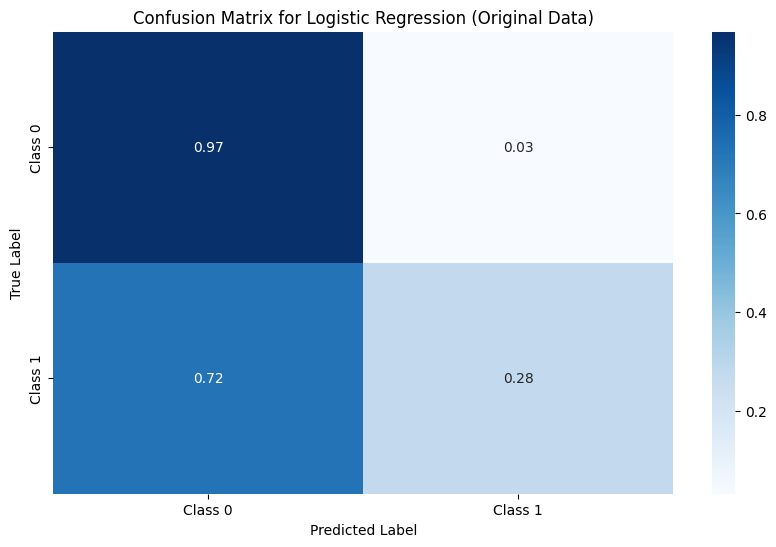

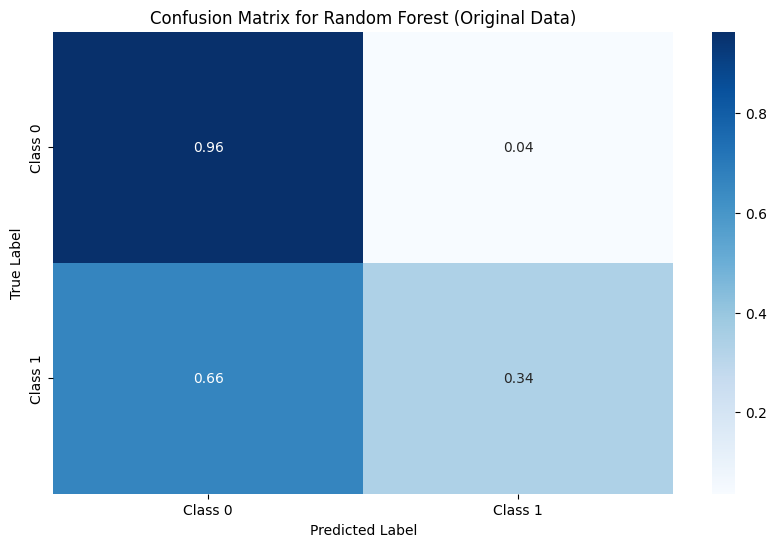

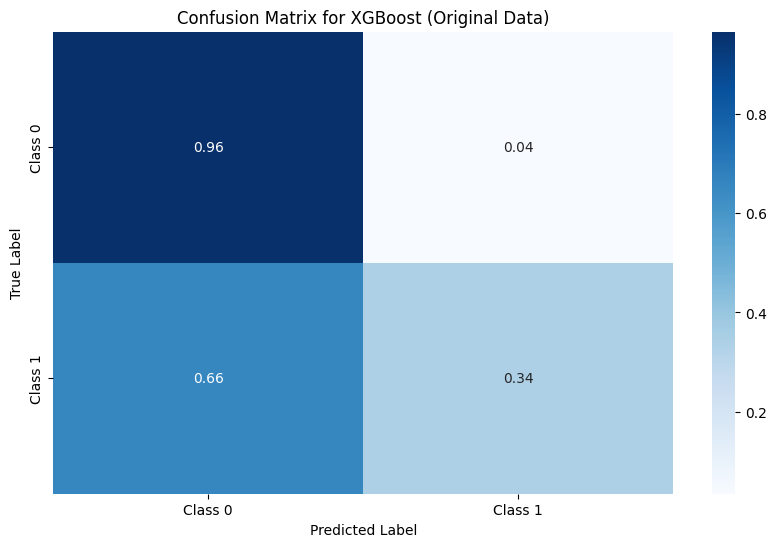

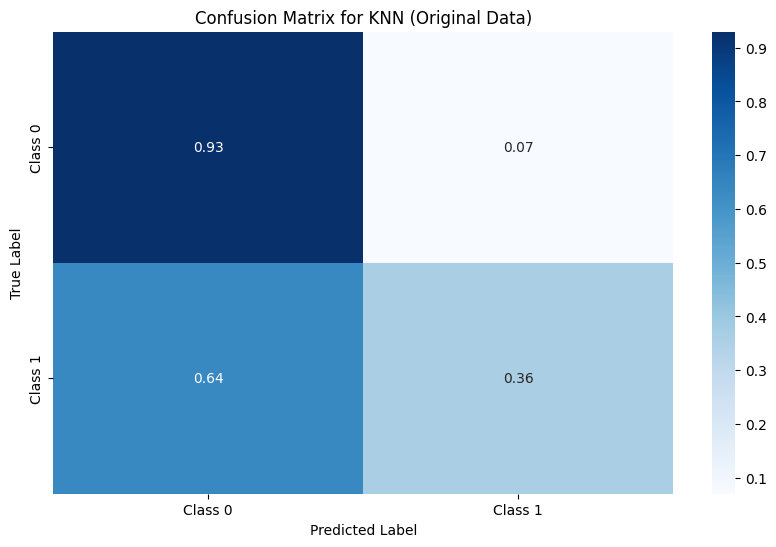

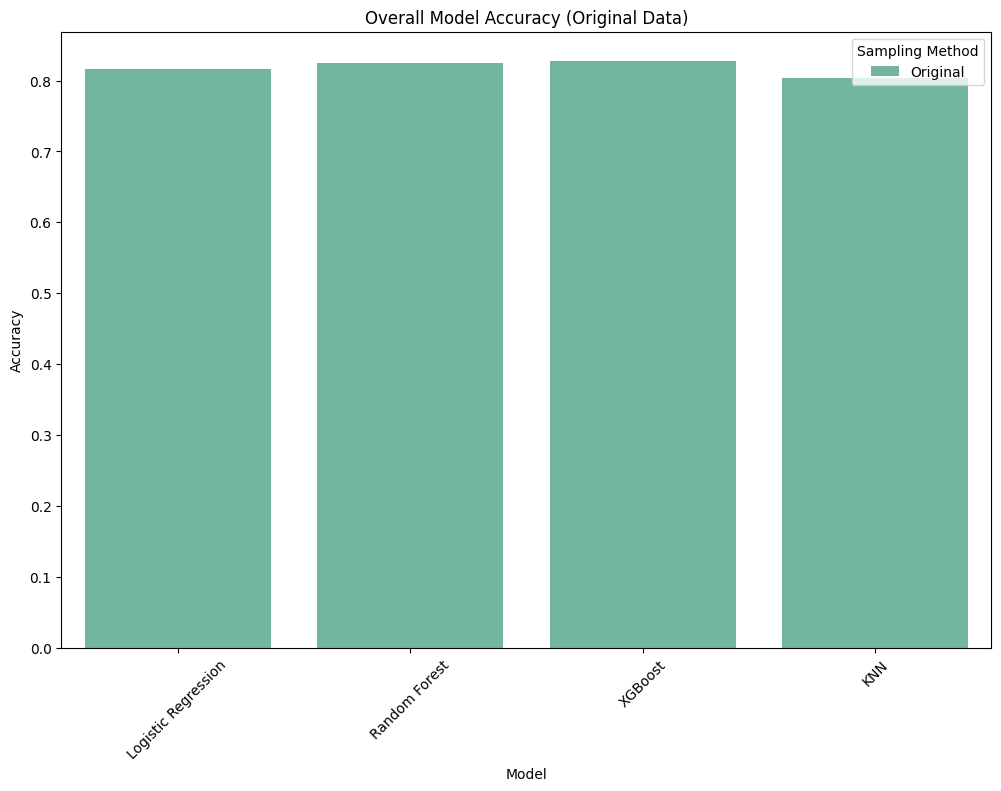

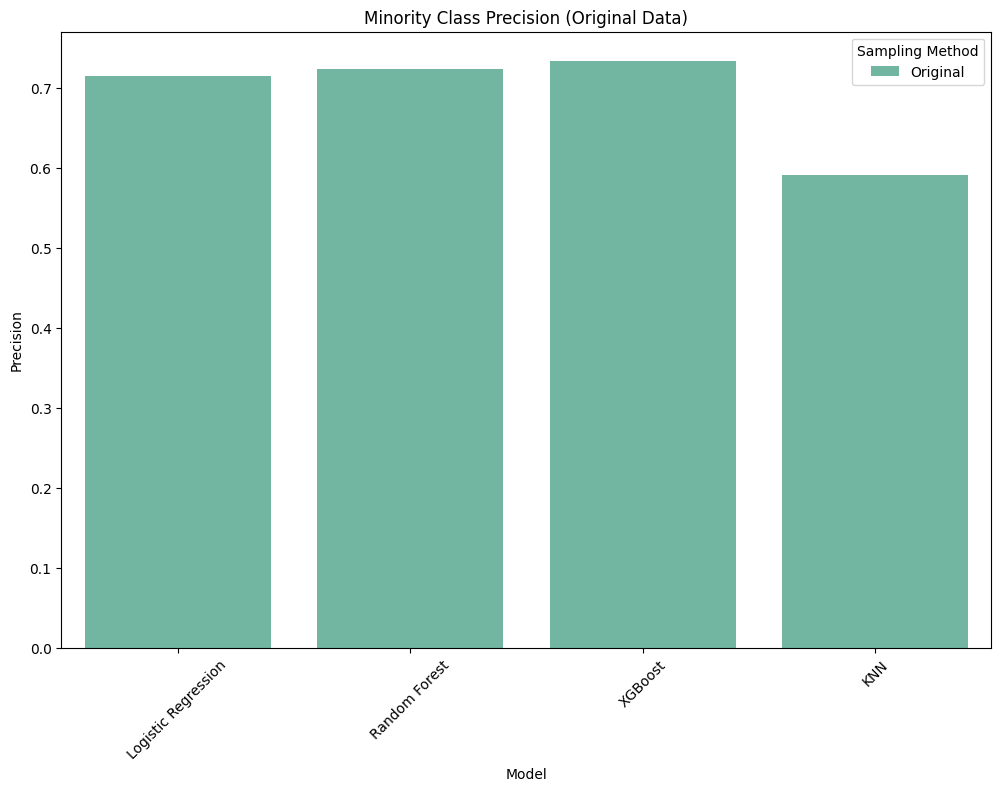

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.815858            0.714230         0.275249   
1        Random Forest  0.825453            0.723876         0.337271   
2              XGBoost  0.827448            0.733306         0.342073   
3                  KNN  0.803834            0.591010         0.359117   

   Minority F1 Sampling Method  
0     0.397363        Original  
1     0.460148        Original  
2     0.466522        Original  
3     0.446765        Original  


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'Original'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (Original Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_original = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_original, palette='Set2')
plt.title('Overall Model Accuracy (Original Data)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_original, palette='Set2')
plt.title('Minority Class Precision (Original Data)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_original)


In [14]:
print(report)

{'0': {'precision': 0.8367705756766645, 'recall': 0.9296768361856114, 'f1-score': 0.8807805046267028, 'support': 164839}, '1': {'precision': 0.5910101259570264, 'recall': 0.35911673276878553, 'f1-score': 0.4467648157038459, 'support': 46645}, 'accuracy': 0.8038338597718976, 'macro avg': {'precision': 0.7138903508168455, 'recall': 0.6443967844771985, 'f1-score': 0.6637726601652744, 'support': 211484}, 'weighted avg': {'precision': 0.7825655475082333, 'recall': 0.8038338597718976, 'f1-score': 0.785053821710706, 'support': 211484}}


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88    164839
           1       0.59      0.36      0.45     46645

    accuracy                           0.80    211484
   macro avg       0.71      0.64      0.66    211484
weighted avg       0.78      0.80      0.79    211484



# ADASYN

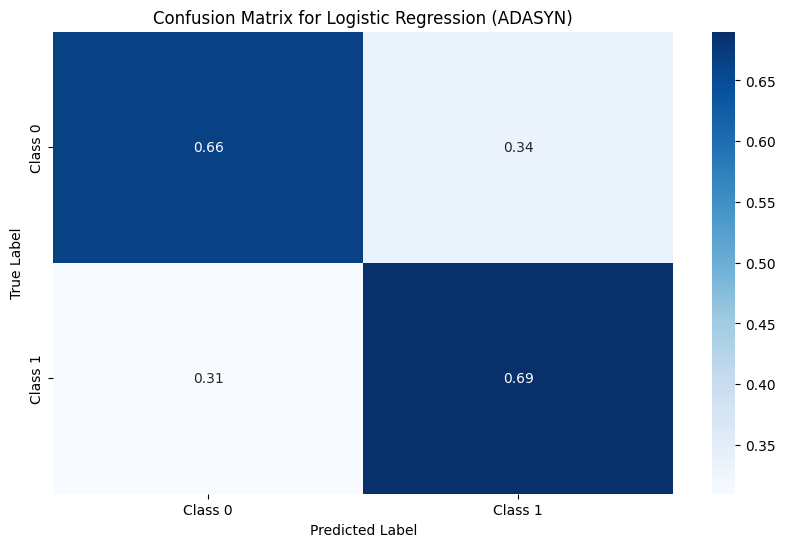

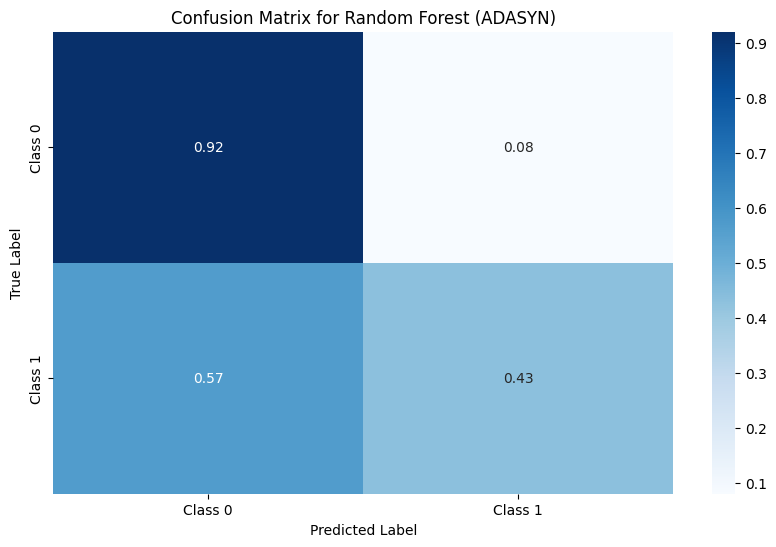

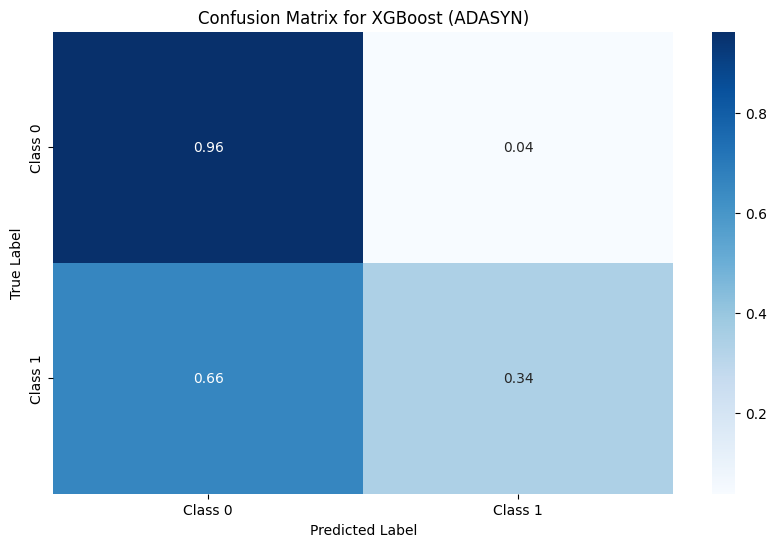

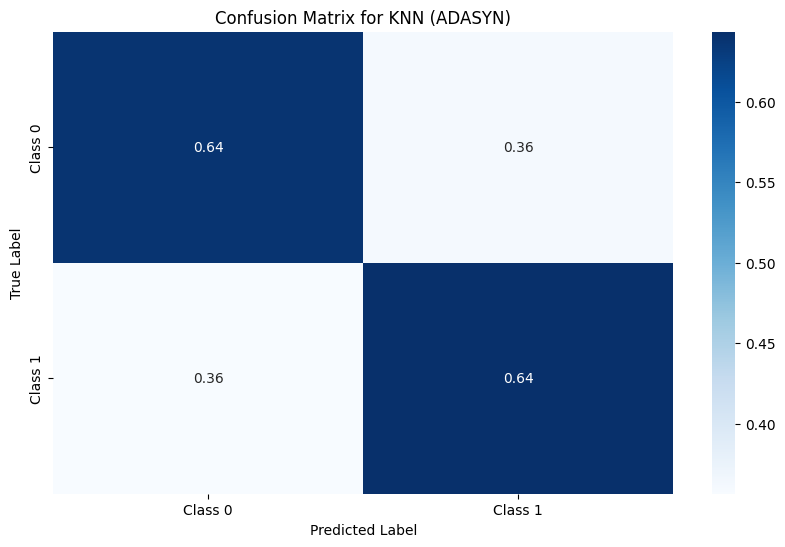

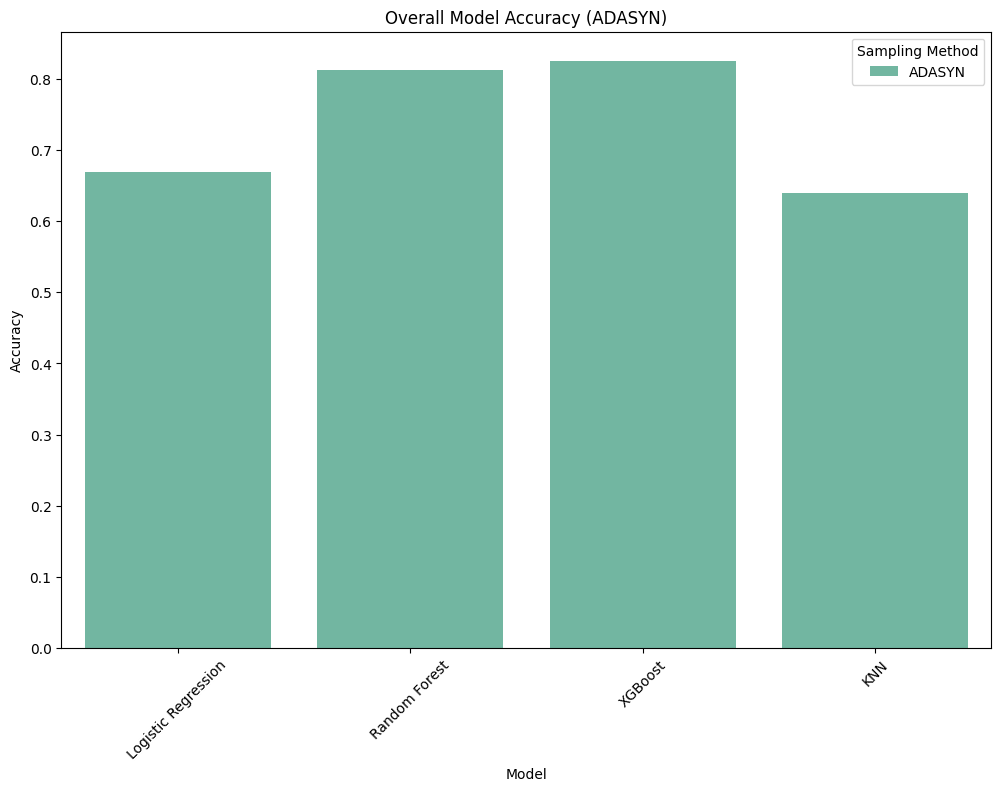

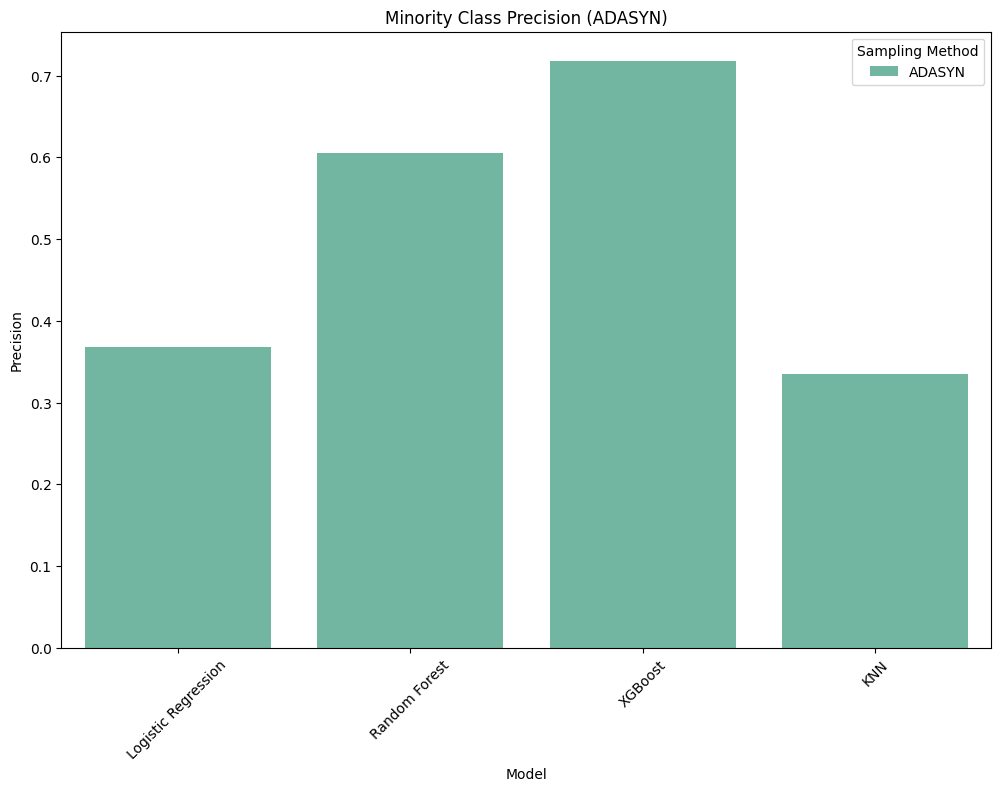

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.669942            0.367721         0.690042   
1        Random Forest  0.812530            0.605189         0.431579   
2              XGBoost  0.825377            0.717640         0.343381   
3                  KNN  0.639807            0.335127         0.643413   

   Minority F1 Sampling Method  
0     0.479773          ADASYN  
1     0.503848          ADASYN  
2     0.464503          ADASYN  
3     0.440708          ADASYN  


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'ADASYN'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (ADASYN)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_adasyn = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_adasyn, palette='Set2')
plt.title('Overall Model Accuracy (ADASYN)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_adasyn, palette='Set2')
plt.title('Minority Class Precision (ADASYN)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_adasyn)


# Random undersampling method

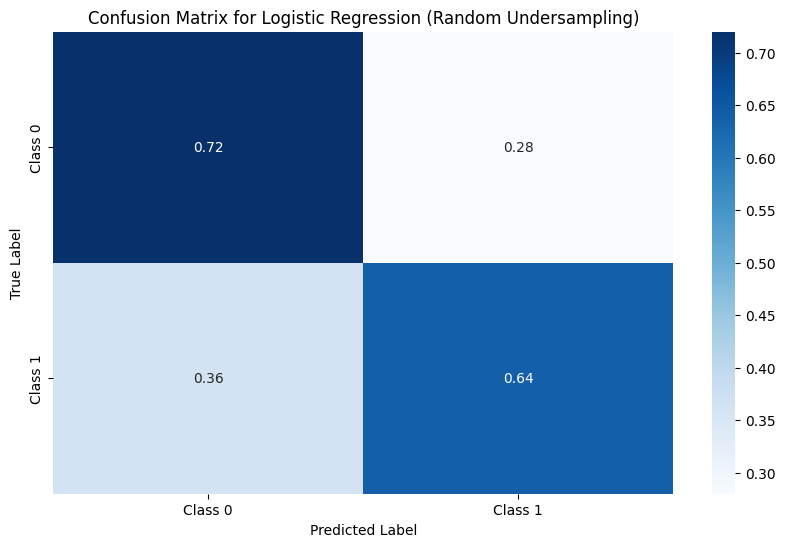

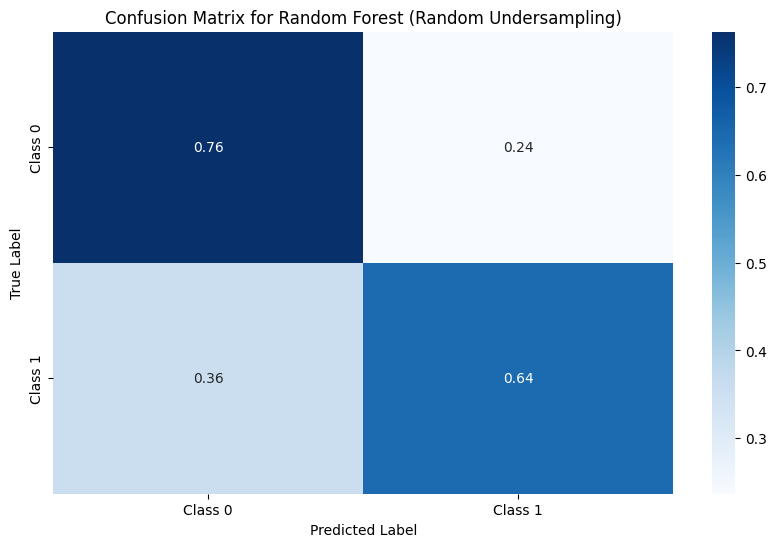

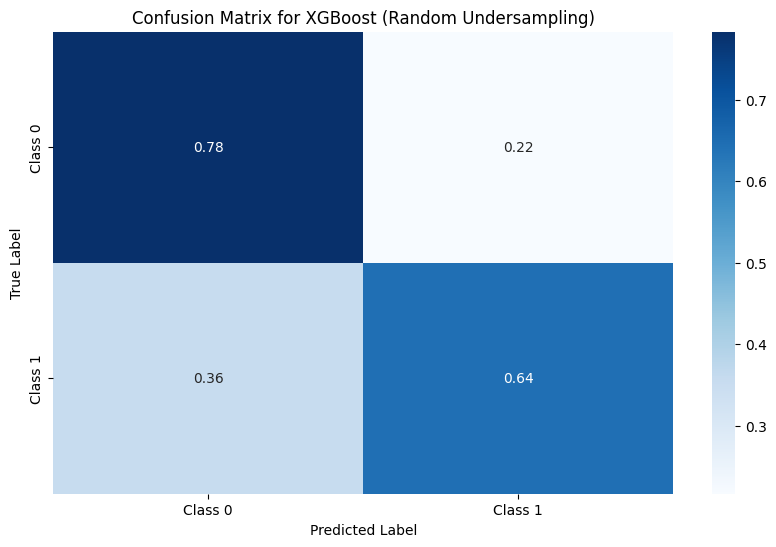

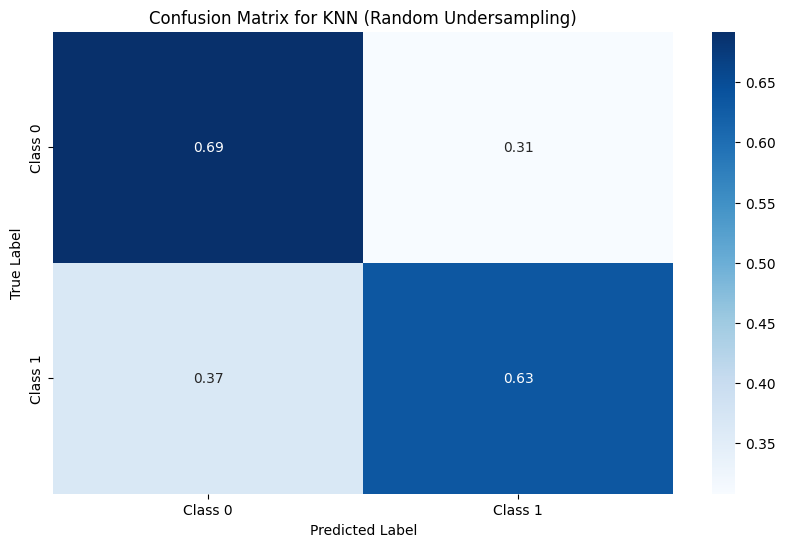

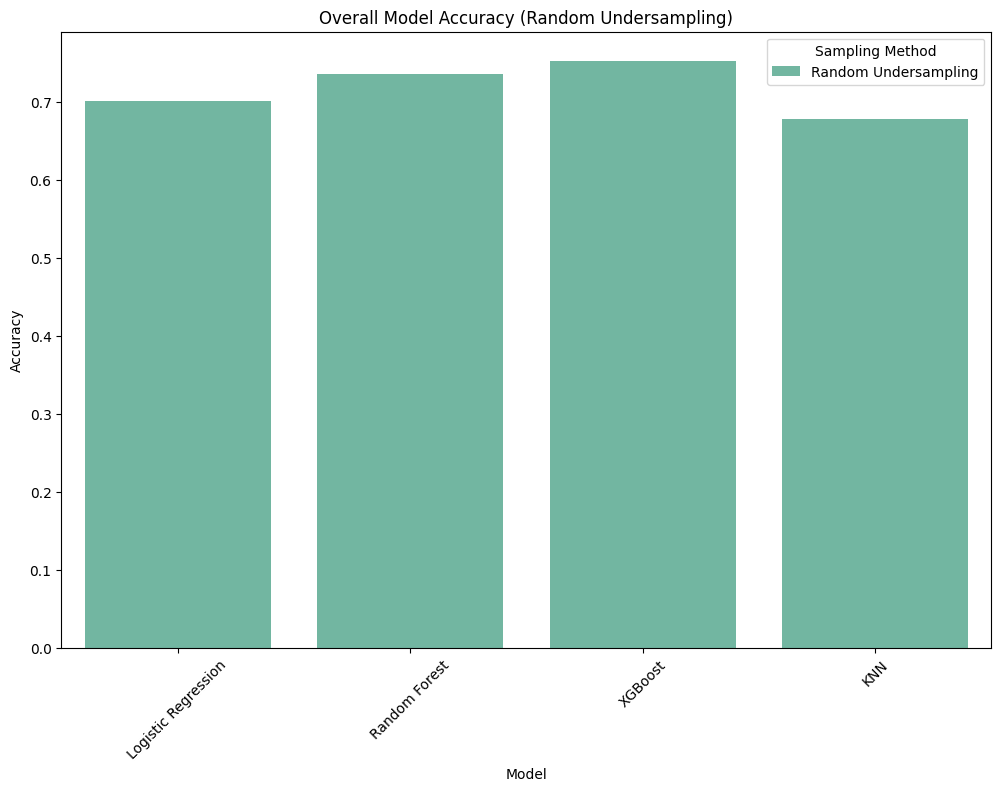

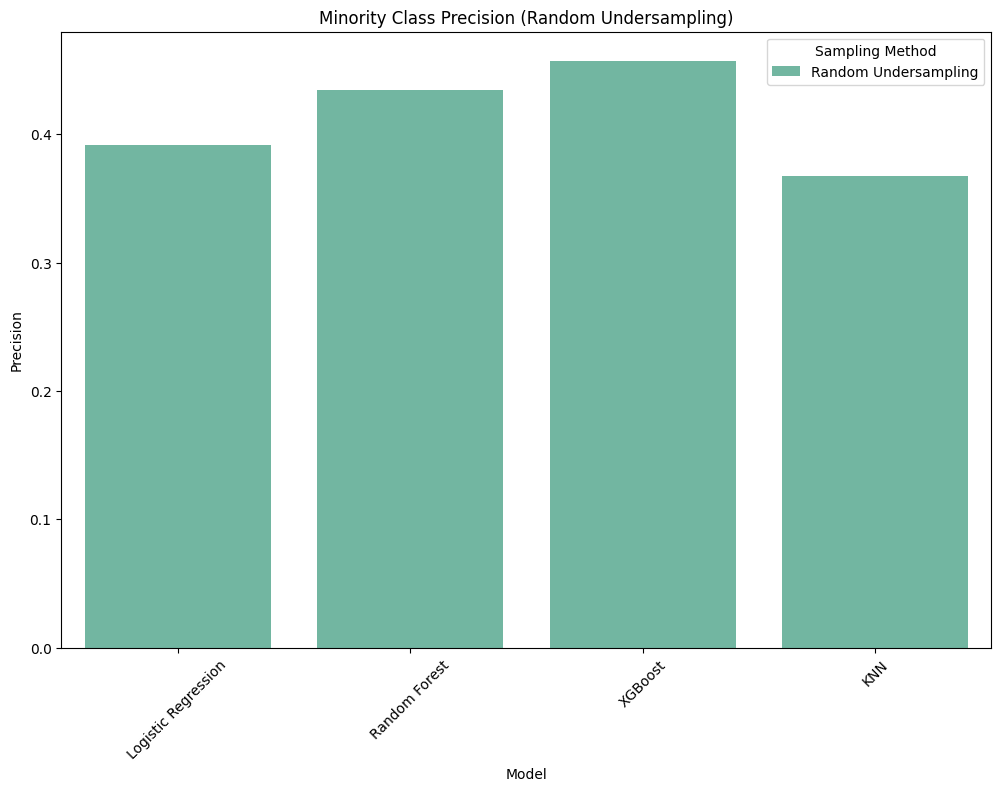

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.701656            0.391671         0.637539   
1        Random Forest  0.736675            0.434430         0.642298   
2              XGBoost  0.752752            0.457077         0.644249   
3                  KNN  0.679077            0.367897         0.633616   

   Minority F1       Sampling Method  
0     0.485237  Random Undersampling  
1     0.518299  Random Undersampling  
2     0.534758  Random Undersampling  
3     0.465506  Random Undersampling  


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply Random Undersampling to the majority class
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'Random Undersampling'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (Random Undersampling)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_undersampling = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_undersampling, palette='Set2')
plt.title('Overall Model Accuracy (Random Undersampling)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_undersampling, palette='Set2')
plt.title('Minority Class Precision (Random Undersampling)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_undersampling)


# SMOTE Method

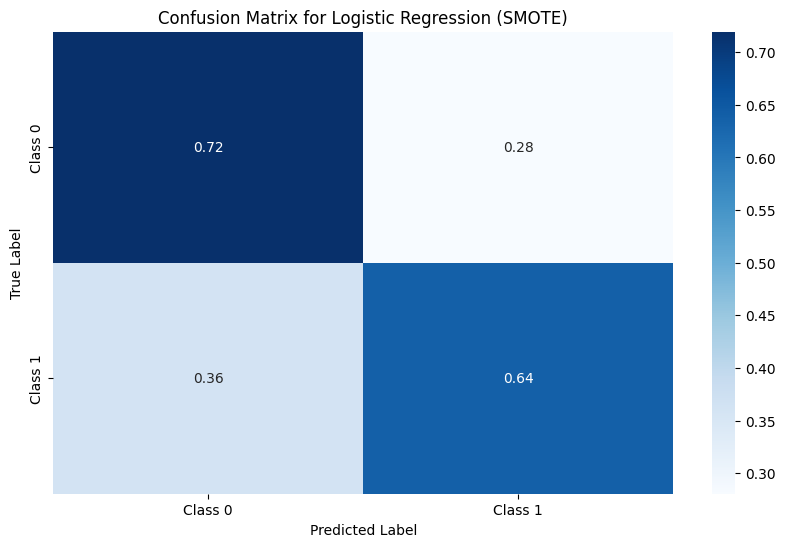

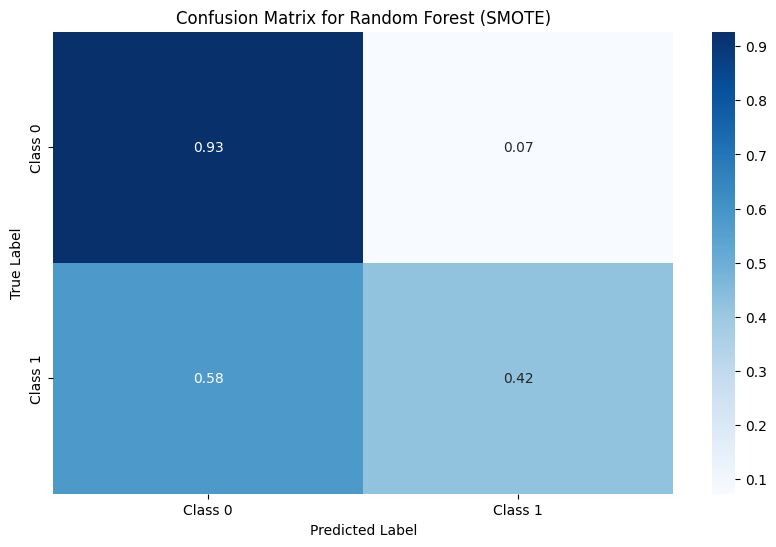

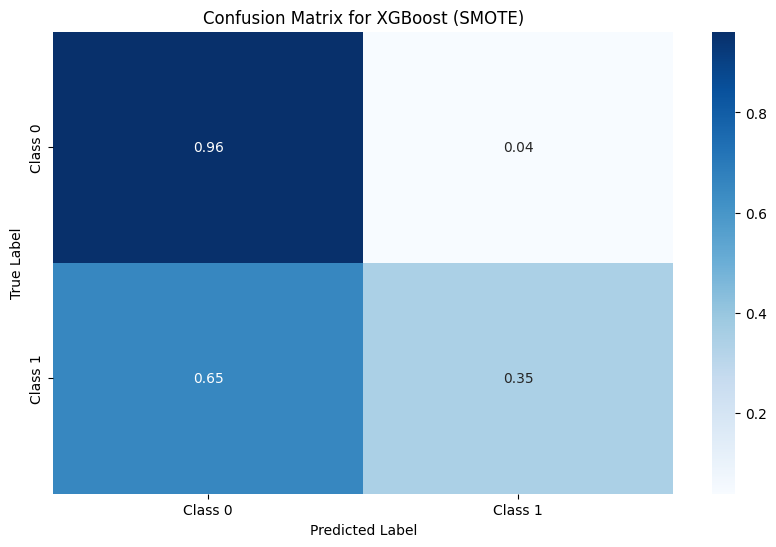

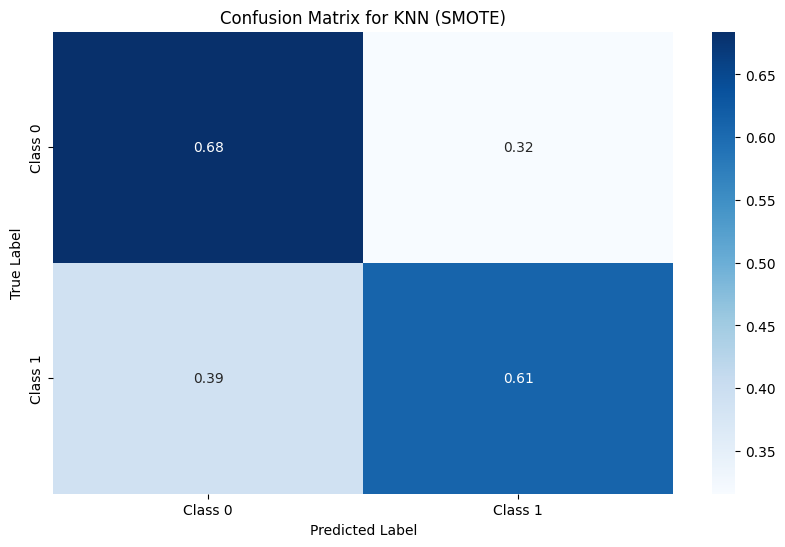

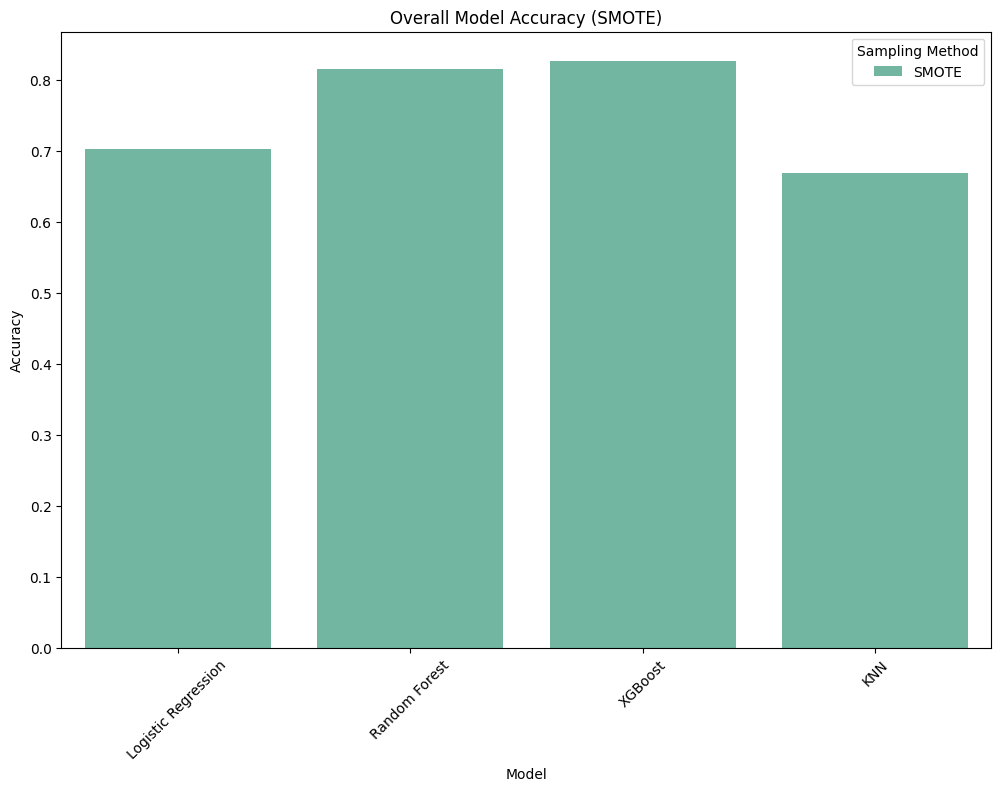

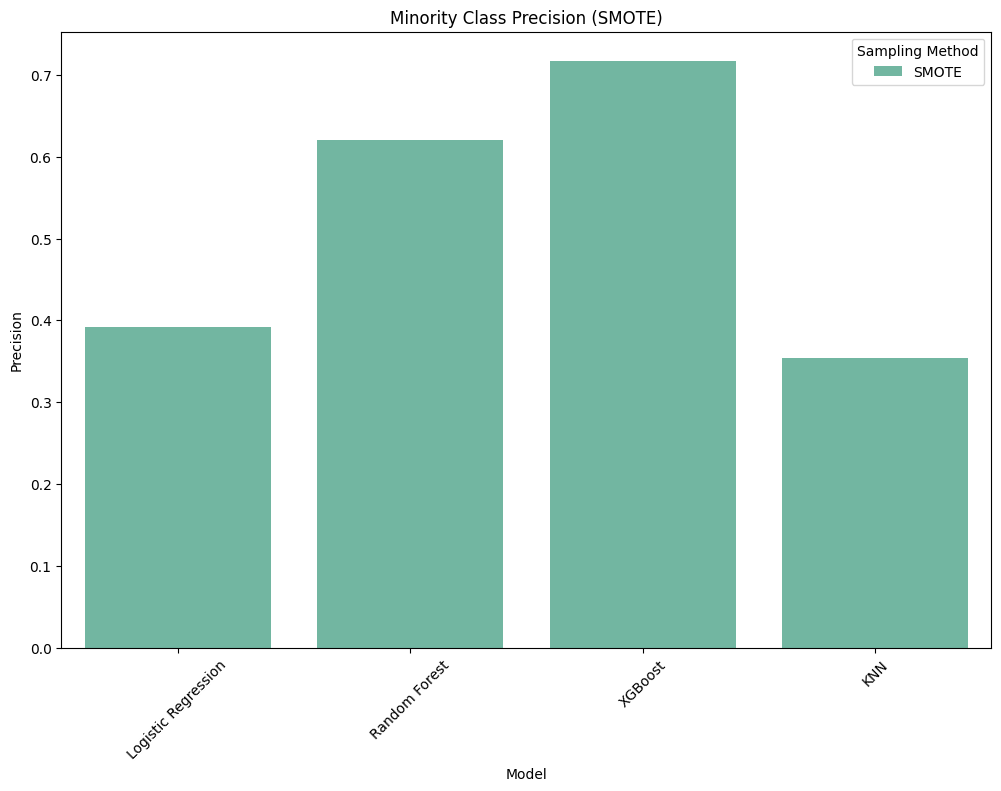

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.701604            0.391779         0.638782   
1        Random Forest  0.815461            0.619908         0.422167   
2              XGBoost  0.825925            0.716876         0.348333   
3                  KNN  0.667824            0.353485         0.610462   

   Minority F1 Sampling Method  
0     0.485680           SMOTE  
1     0.502276           SMOTE  
2     0.468850           SMOTE  
3     0.447720           SMOTE  


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'SMOTE'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (SMOTE)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_smote = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_smote, palette='Set2')
plt.title('Overall Model Accuracy (SMOTE)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_smote, palette='Set2')
plt.title('Minority Class Precision (SMOTE)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_smote)


# Model Comparision using different sampling mehtods

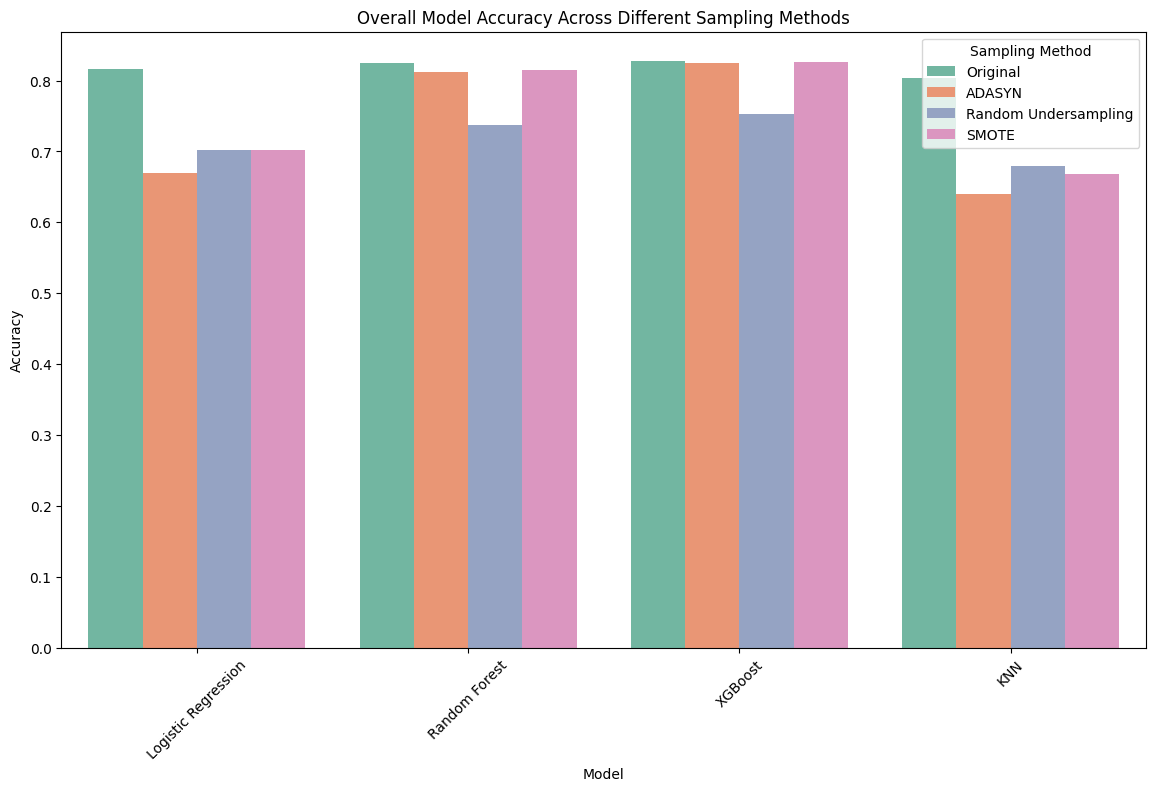

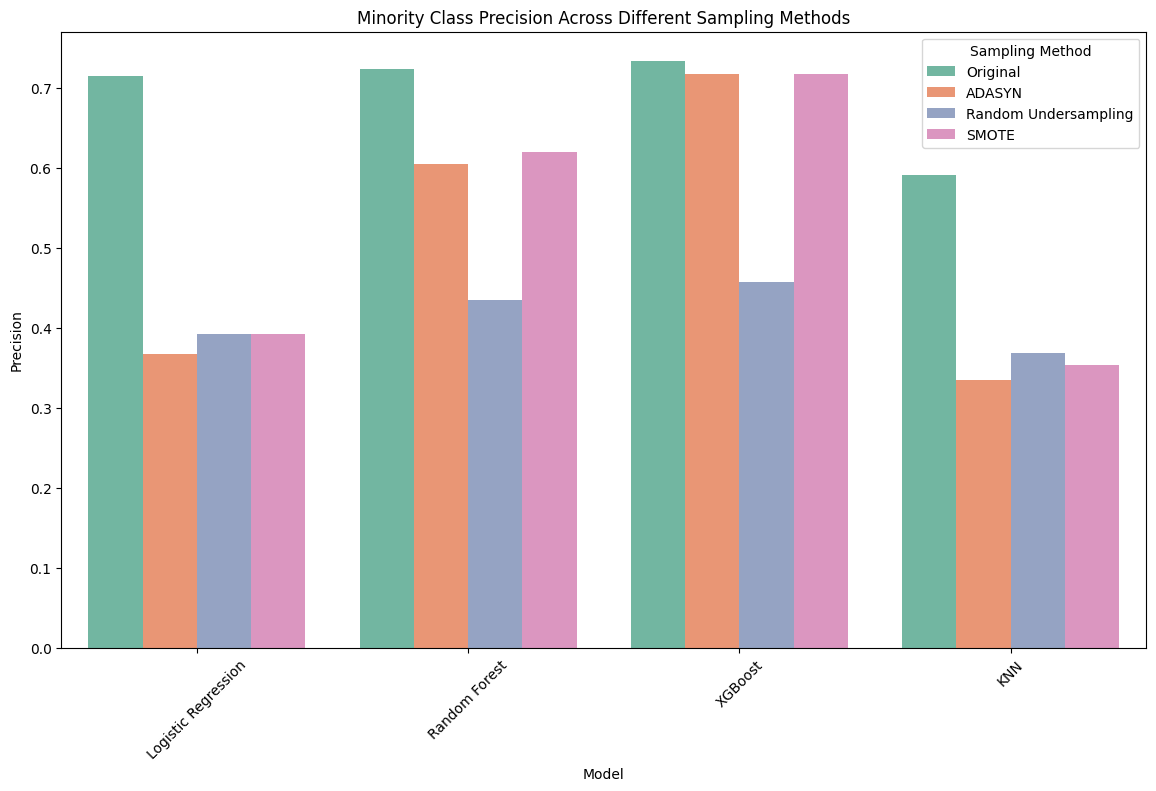

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine results from all sampling methods
all_results = pd.concat([results_original, results_adasyn, results_undersampling, results_smote])

# Plot overall model accuracy comparison across all sampling methods
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=all_results, palette='Set2')
plt.title('Overall Model Accuracy Across Different Sampling Methods')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Minority Class Precision comparison across all sampling methods
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=all_results, palette='Set2')
plt.title('Minority Class Precision Across Different Sampling Methods')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()


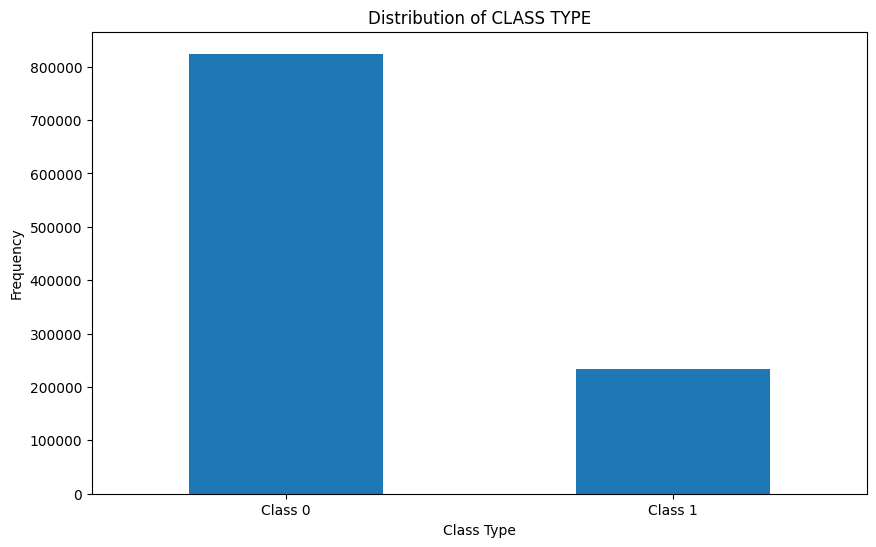

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the distribution of the 'CLASS TYPE' column
plt.figure(figsize=(10, 6))
mvc_processed['CLASS TYPE'].value_counts().plot(kind='bar')
plt.title('Distribution of CLASS TYPE')
plt.xlabel('Class Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Calculate the scale_pos_weight value for imbalanced classification
unique, counts = np.unique(y_train, return_counts=True)
class_ratio = counts[0] / counts[1]

model = XGBClassifier(scale_pos_weight=class_ratio, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.89      0.79      0.83    164839
           1       0.46      0.64      0.54     46645

    accuracy                           0.76    211484
   macro avg       0.67      0.71      0.69    211484
weighted avg       0.79      0.76      0.77    211484

ROC AUC Score: 0.49087539300594607


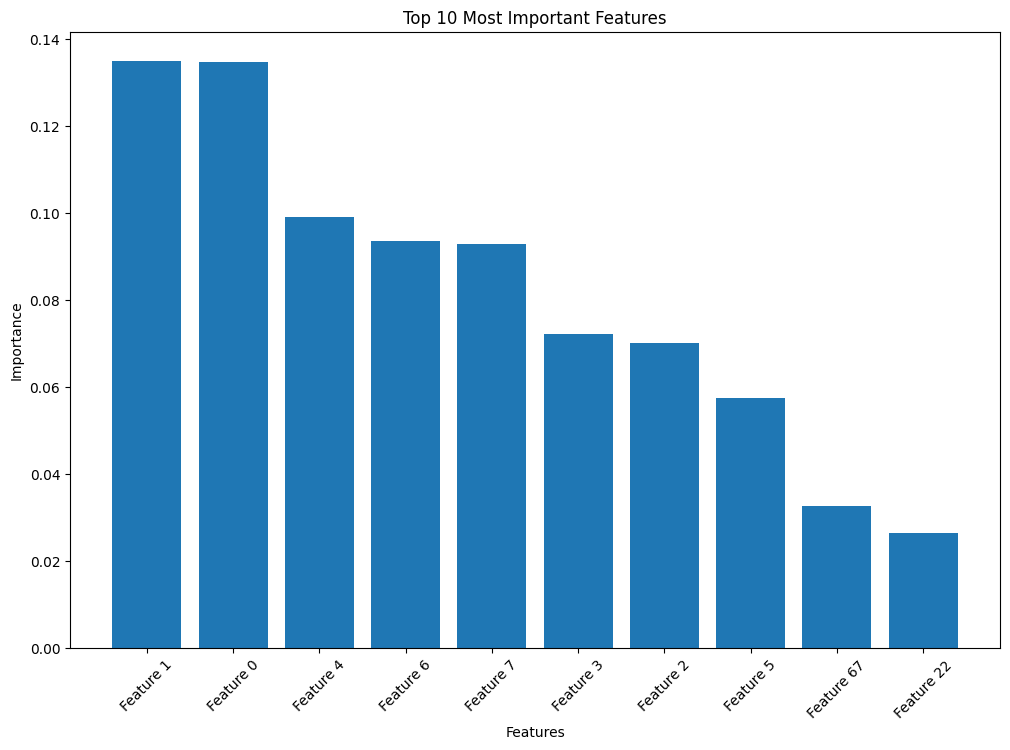

In [26]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_

# If feature names are not available, use feature indices
feature_names = [f'Feature {i}' for i in range(X_train_scaled.shape[1])]

# Create a DataFrame to view feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])  # Show top 10 features
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')
plt.xticks(rotation=45)
plt.show()

N = 10
most_important_features_indices = feature_importance_df.index[:N]

# Reduce X_train and X_test to the most important features
X_train_reduced = X_train_scaled[:, most_important_features_indices]
X_test_reduced = X_test_scaled[:, most_important_features_indices]


Results for Logistic Regression:
Accuracy: 0.78800287492198
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    164839
           1       0.61      0.11      0.19     46645

    accuracy                           0.79    211484
   macro avg       0.70      0.54      0.53    211484
weighted avg       0.75      0.79      0.73    211484


--------------------------------------------------

Results for Random Forest (Balanced):
Accuracy: 0.8062879461330408
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89    164839
           1       0.68      0.23      0.35     46645

    accuracy                           0.81    211484
   macro avg       0.75      0.60      0.62    211484
weighted avg       0.79      0.81      0.77    211484


--------------------------------------------------

Results for XGBoost:
Accuracy: 0.8080374874695012
Classification Re

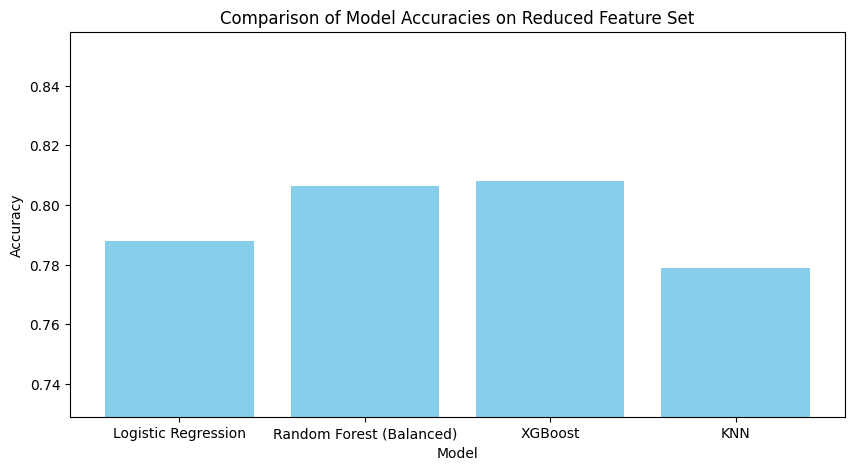

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest (Balanced)': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results.append((name, accuracy, report))

    print(f"Results for {name}:")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)
    print("\n" + "-"*50 + "\n")

# Collect and plot all accuracies for visual comparison
import matplotlib.pyplot as plt

# Extracting model names and their accuracies
model_names = [result[0] for result in results]
accuracies = [result[1] for result in results]

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies on Reduced Feature Set')
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
plt.show()


In [32]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Step 1: Initialize PCA and the Logistic Regression model
pca = PCA(n_components=0.95)
logistic = LogisticRegression(max_iter=1000)

# Step 2: Create a pipeline
pipeline = make_pipeline(pca, logistic)

# Step 3: Train the model
pipeline.fit(X_train_scaled, y_train)

# Step 4: Predict and evaluate the model
y_pred = pipeline.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.98      0.89    164839
           1       0.77      0.21      0.33     46645

    accuracy                           0.81    211484
   macro avg       0.79      0.60      0.61    211484
weighted avg       0.81      0.81      0.77    211484



In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Set up PCA and XGBoost
pca = PCA(n_components=0.95)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 2: Create a pipeline
pipeline = Pipeline([('pca', pca), ('xgb', xgb)])

# Step 3: Train the pipeline
pipeline.fit(X_train_scaled, y_train)

# Step 4: Predict and evaluate
y_pred = pipeline.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.8027794064799229
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88    164839
           1       0.66      0.22      0.33     46645

    accuracy                           0.80    211484
   macro avg       0.74      0.60      0.61    211484
weighted avg       0.78      0.80      0.76    211484



In [38]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Define the pipeline
pipeline = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
])

# Step 2: Define the parameter grid
param_grid = {
    'pca__n_components': [0.85, 0.90, 0.95],
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [50, 100, 150]
}

# Step 3: Setup Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# Step 4: Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Step 5: Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'pca__n_components': 0.95, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}
Best cross-validation score: 0.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Test set score: 0.82


In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)


In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score

# Initialize the LDA model
lda_classifier = LDA()

# Train the model
lda_classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = lda_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.7058973728509013
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.79    164839
           1       0.40      0.63      0.49     46645

    accuracy                           0.71    211484
   macro avg       0.64      0.68      0.64    211484
weighted avg       0.77      0.71      0.73    211484



In [45]:
mvc_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057417 entries, 0 to 1057416
Data columns (total 19 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   LATITUDE                       1057417 non-null  float64
 1   LONGITUDE                      1057417 non-null  float64
 2   CONTRIBUTING FACTOR VEHICLE 1  1057417 non-null  object 
 3   CONTRIBUTING FACTOR VEHICLE 2  1057417 non-null  object 
 4   CONTRIBUTING FACTOR VEHICLE 3  1057417 non-null  object 
 5   CONTRIBUTING FACTOR VEHICLE 4  1057417 non-null  object 
 6   CONTRIBUTING FACTOR VEHICLE 5  1057417 non-null  object 
 7   VEHICLE TYPE CODE 1            1057417 non-null  object 
 8   VEHICLE TYPE CODE 2            1057417 non-null  object 
 9   VEHICLE TYPE CODE 3            1057417 non-null  object 
 10  VEHICLE TYPE CODE 4            1057417 non-null  object 
 11  VEHICLE TYPE CODE 5            1057417 non-null  object 
 12  CLASS TYPE    

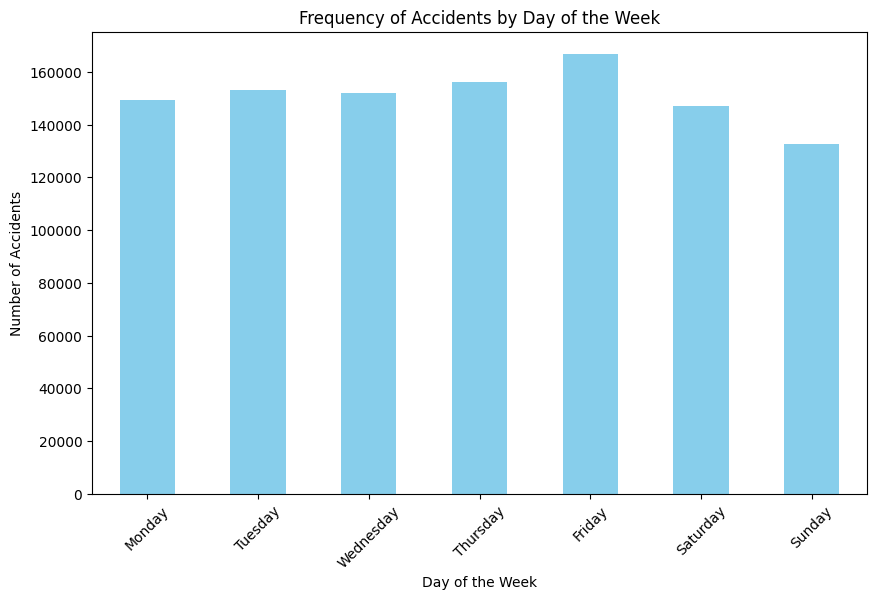

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the frequency of each day
day_counts = mvc_processed['dayofweek'].value_counts().sort_index()

# Map day indices to day names if needed
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts.index = [day_names[day] for day in day_counts.index]

# Create a bar plot
plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


<Axes: >

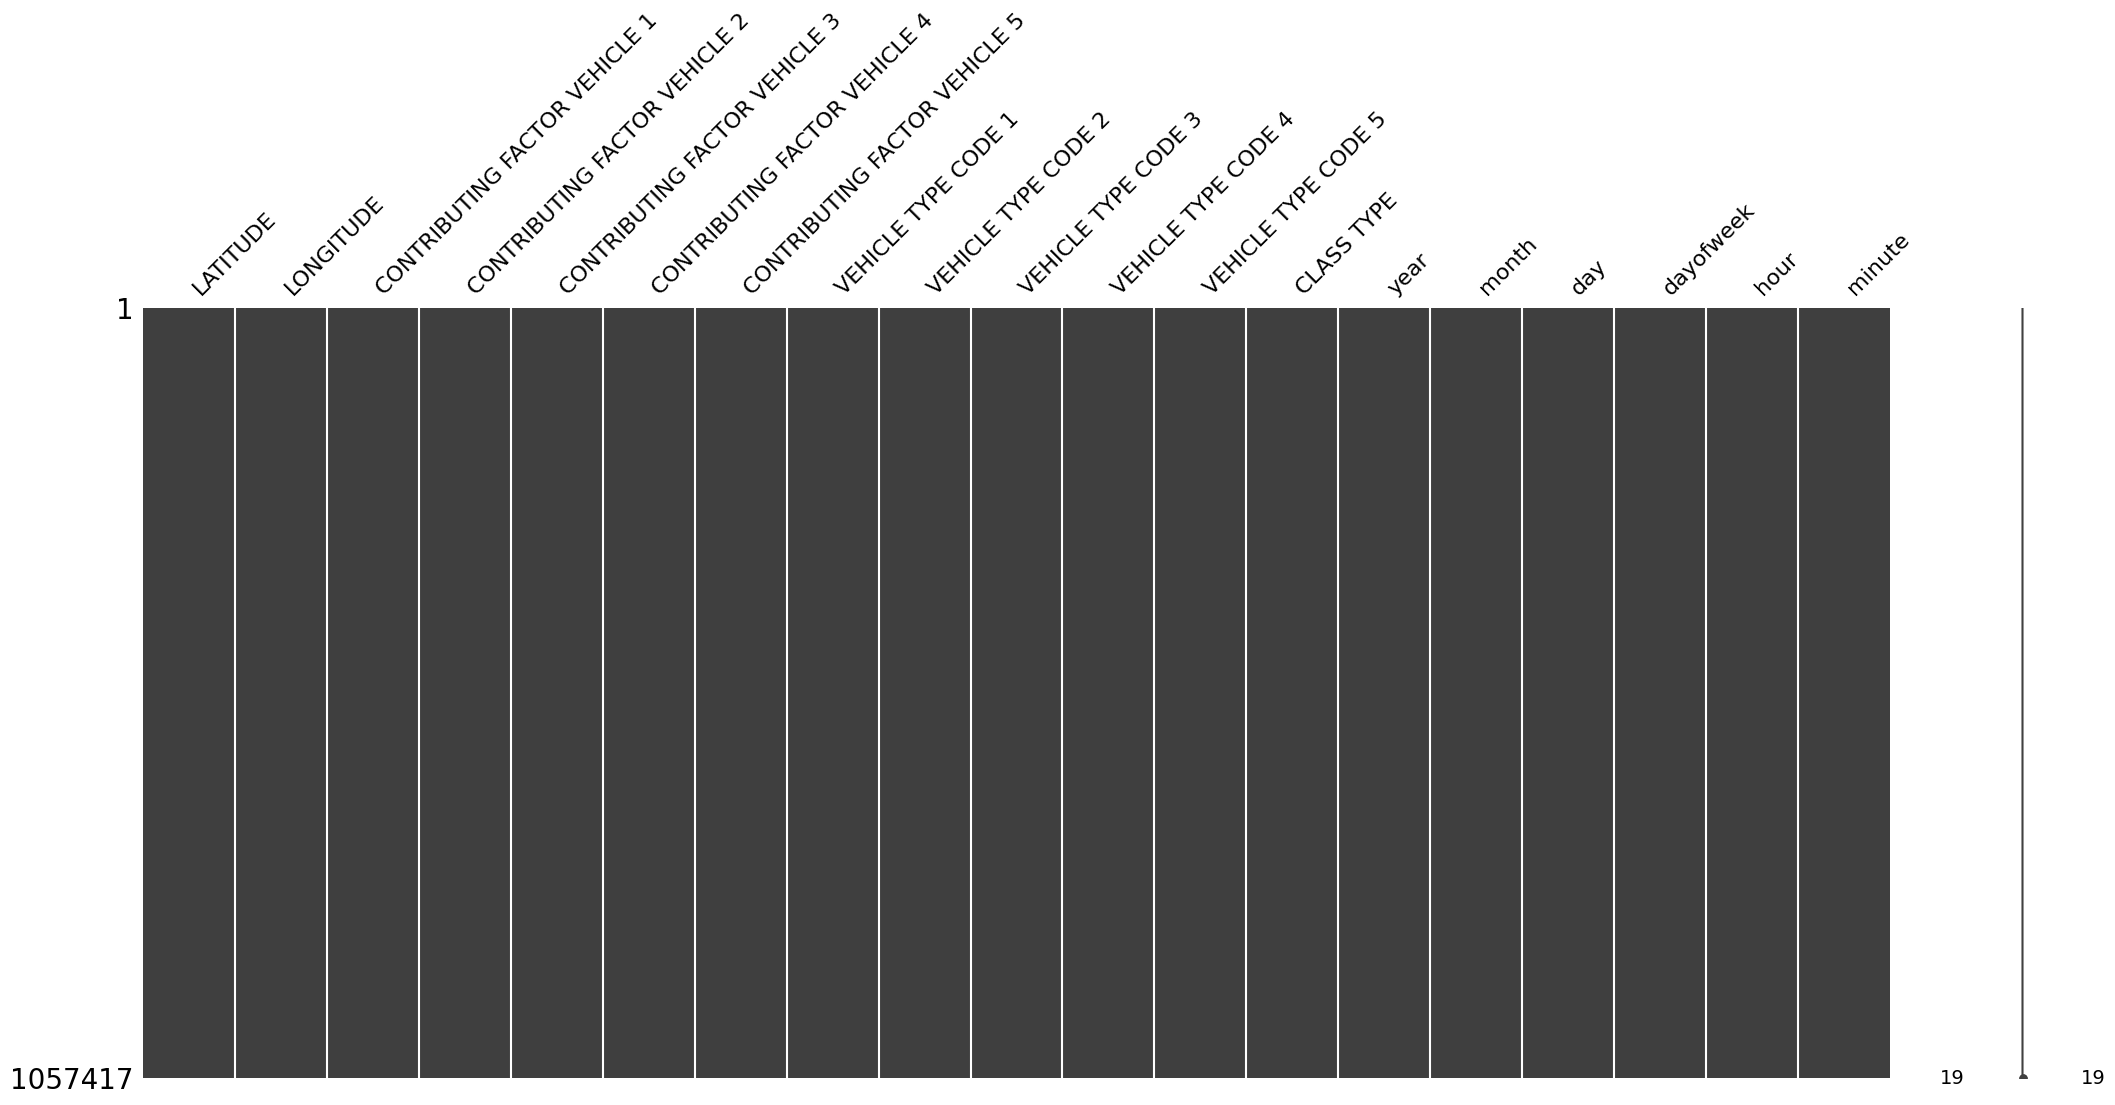

In [47]:
import pandas as pd
import missingno as msno

# Matrix plot to visualize missing data pattern
msno.matrix(mvc_processed)


In [51]:
mvc_preprocessed = pd.read_csv("/Users/adnanarnaout/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adnanarnaout/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv'

In [54]:
import requests
import zipfile
import pandas as pd
from io import BytesIO

url2 = 'https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-nyc-car-accident-severity/blob/main/data/raw/Motor_Vehicle_Collisions_-_Crashes.zip?raw=true'

# Download the zip file
response = requests.get(url2)
zip_content = BytesIO(response.content)

# Unzip the file
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    # Extract all the contents into the current directory
    zip_ref.extractall()

    csv_filename = zip_ref.namelist()[0]

    # Read the CSV file
    mvc_preprocessed = pd.read_csv(csv_filename)

<ipython-input-54-cef4afe7ba59>:20: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mvc_preprocessed = pd.read_csv(csv_filename)


<Axes: >

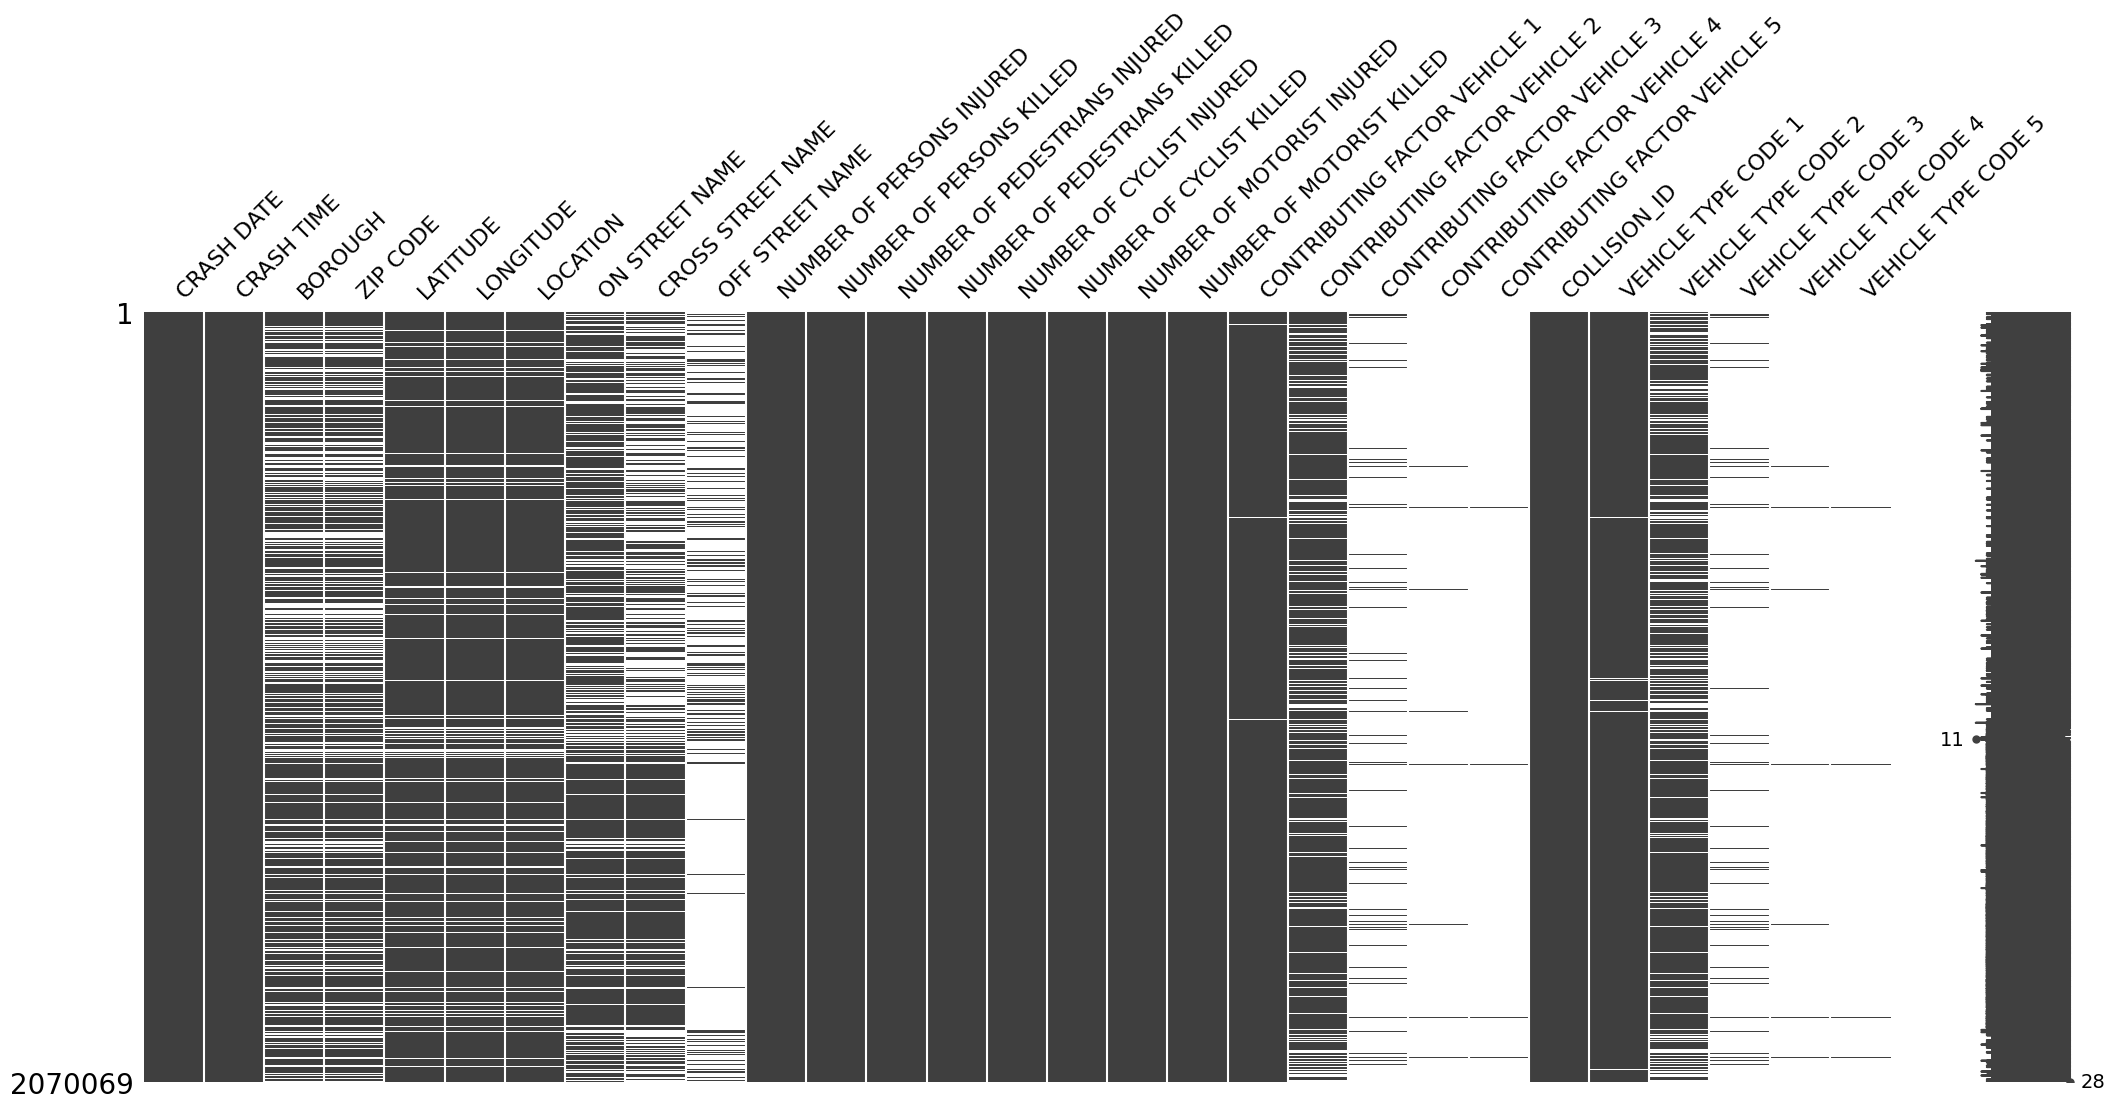

In [55]:
import pandas as pd
import missingno as msno

# Matrix plot to visualize missing data pattern
msno.matrix(mvc_preprocessed)


<Axes: >

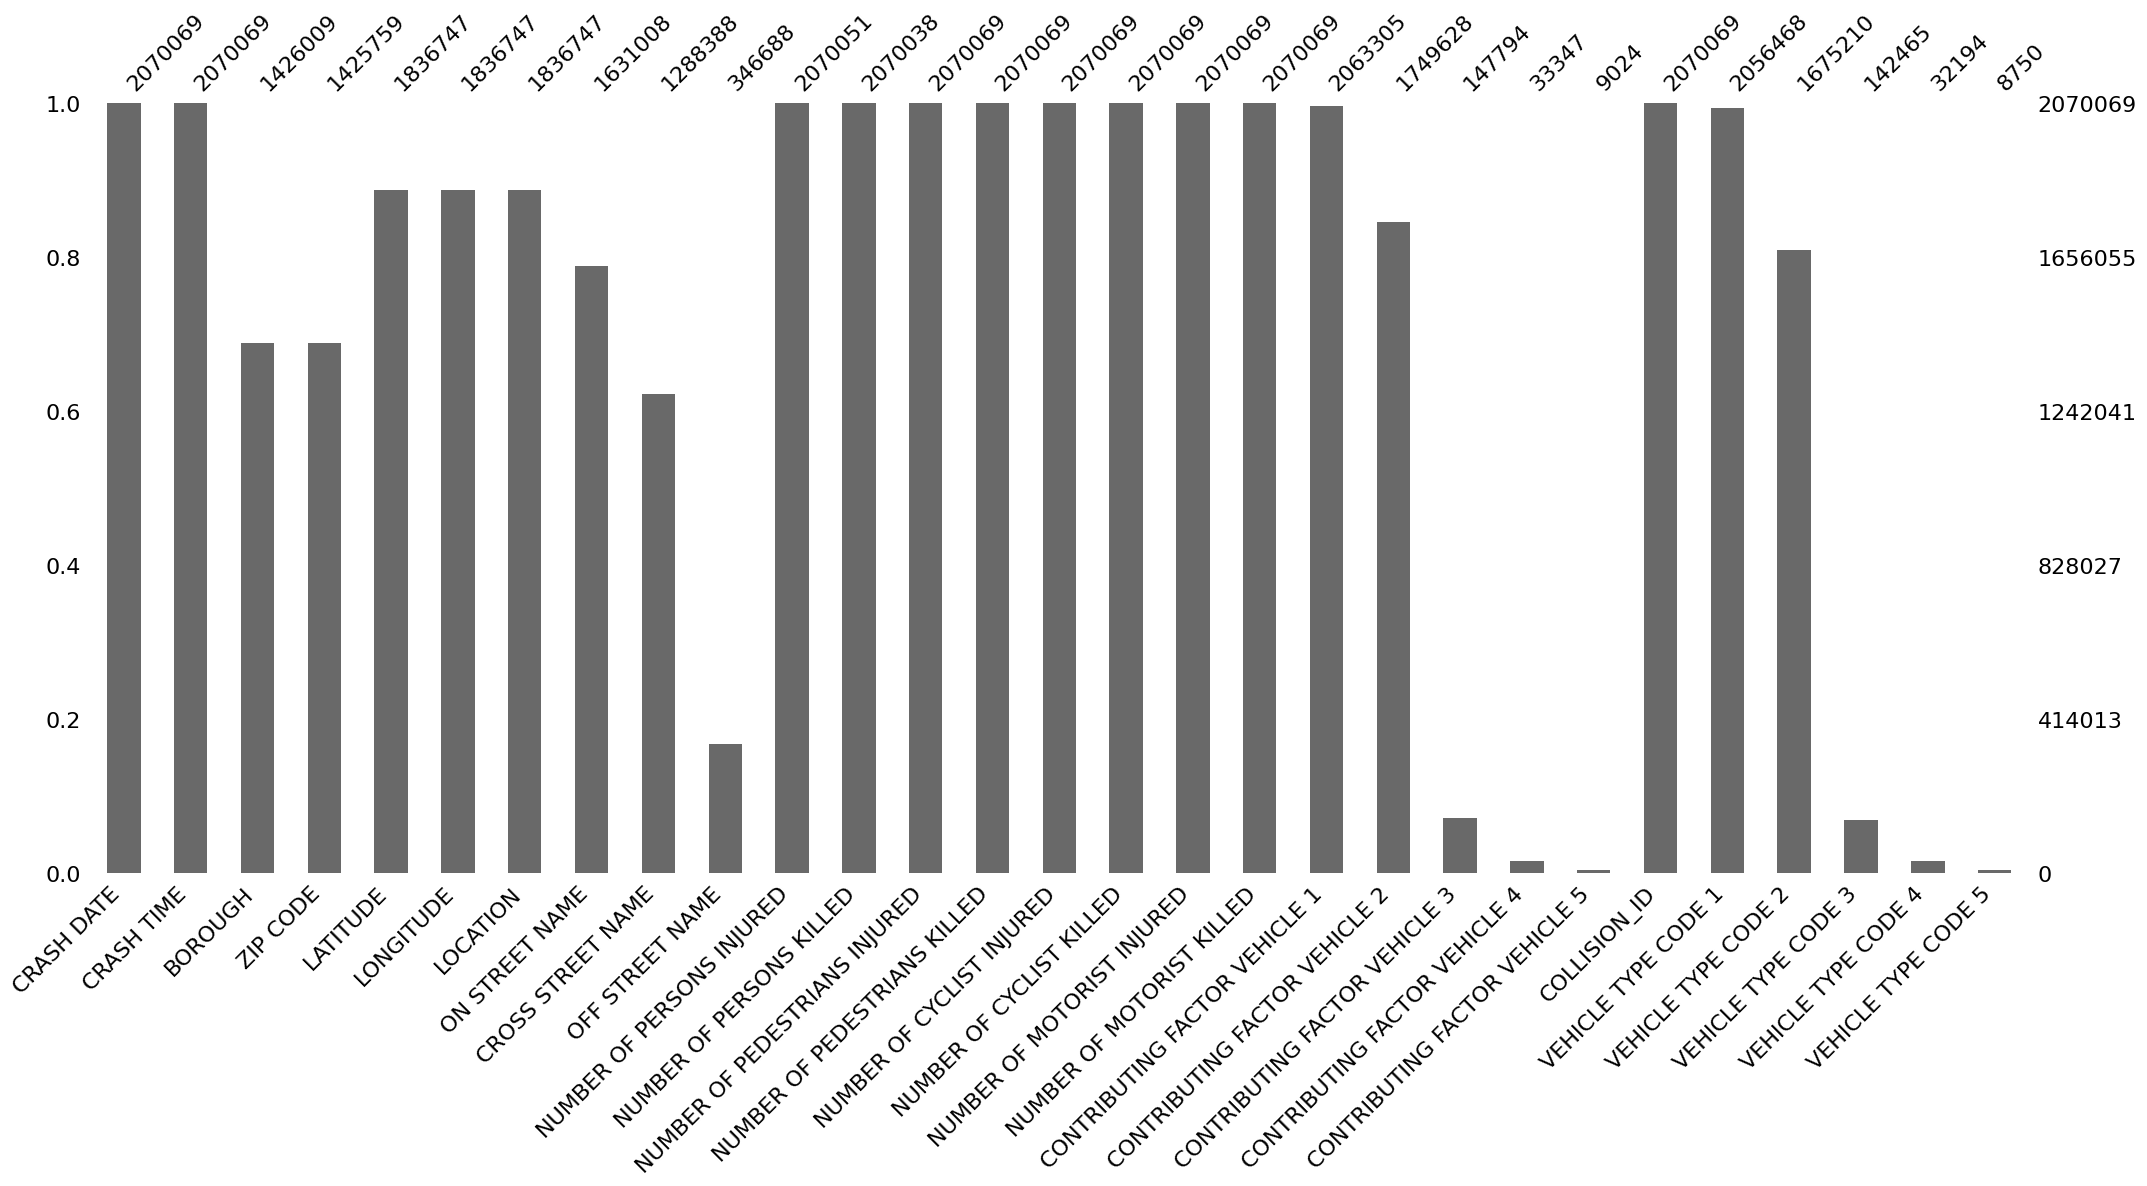

In [56]:
# Bar plot to show the completeness of the data
msno.bar(mvc_preprocessed)


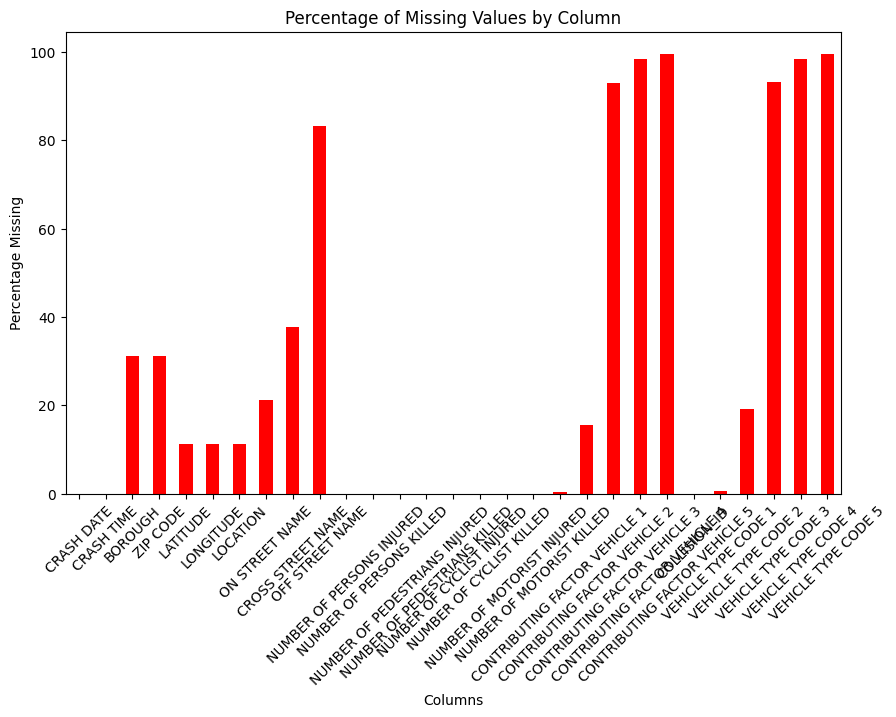

In [59]:
import matplotlib.pyplot as plt

# Calculate the percentage of missing data in each column
missing_percentages = mvc_preprocessed.isnull().mean() * 100

# Plotting
plt.figure(figsize=(10, 6))
missing_percentages.plot(kind='bar', color='red')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45)
plt.show()


<Axes: >

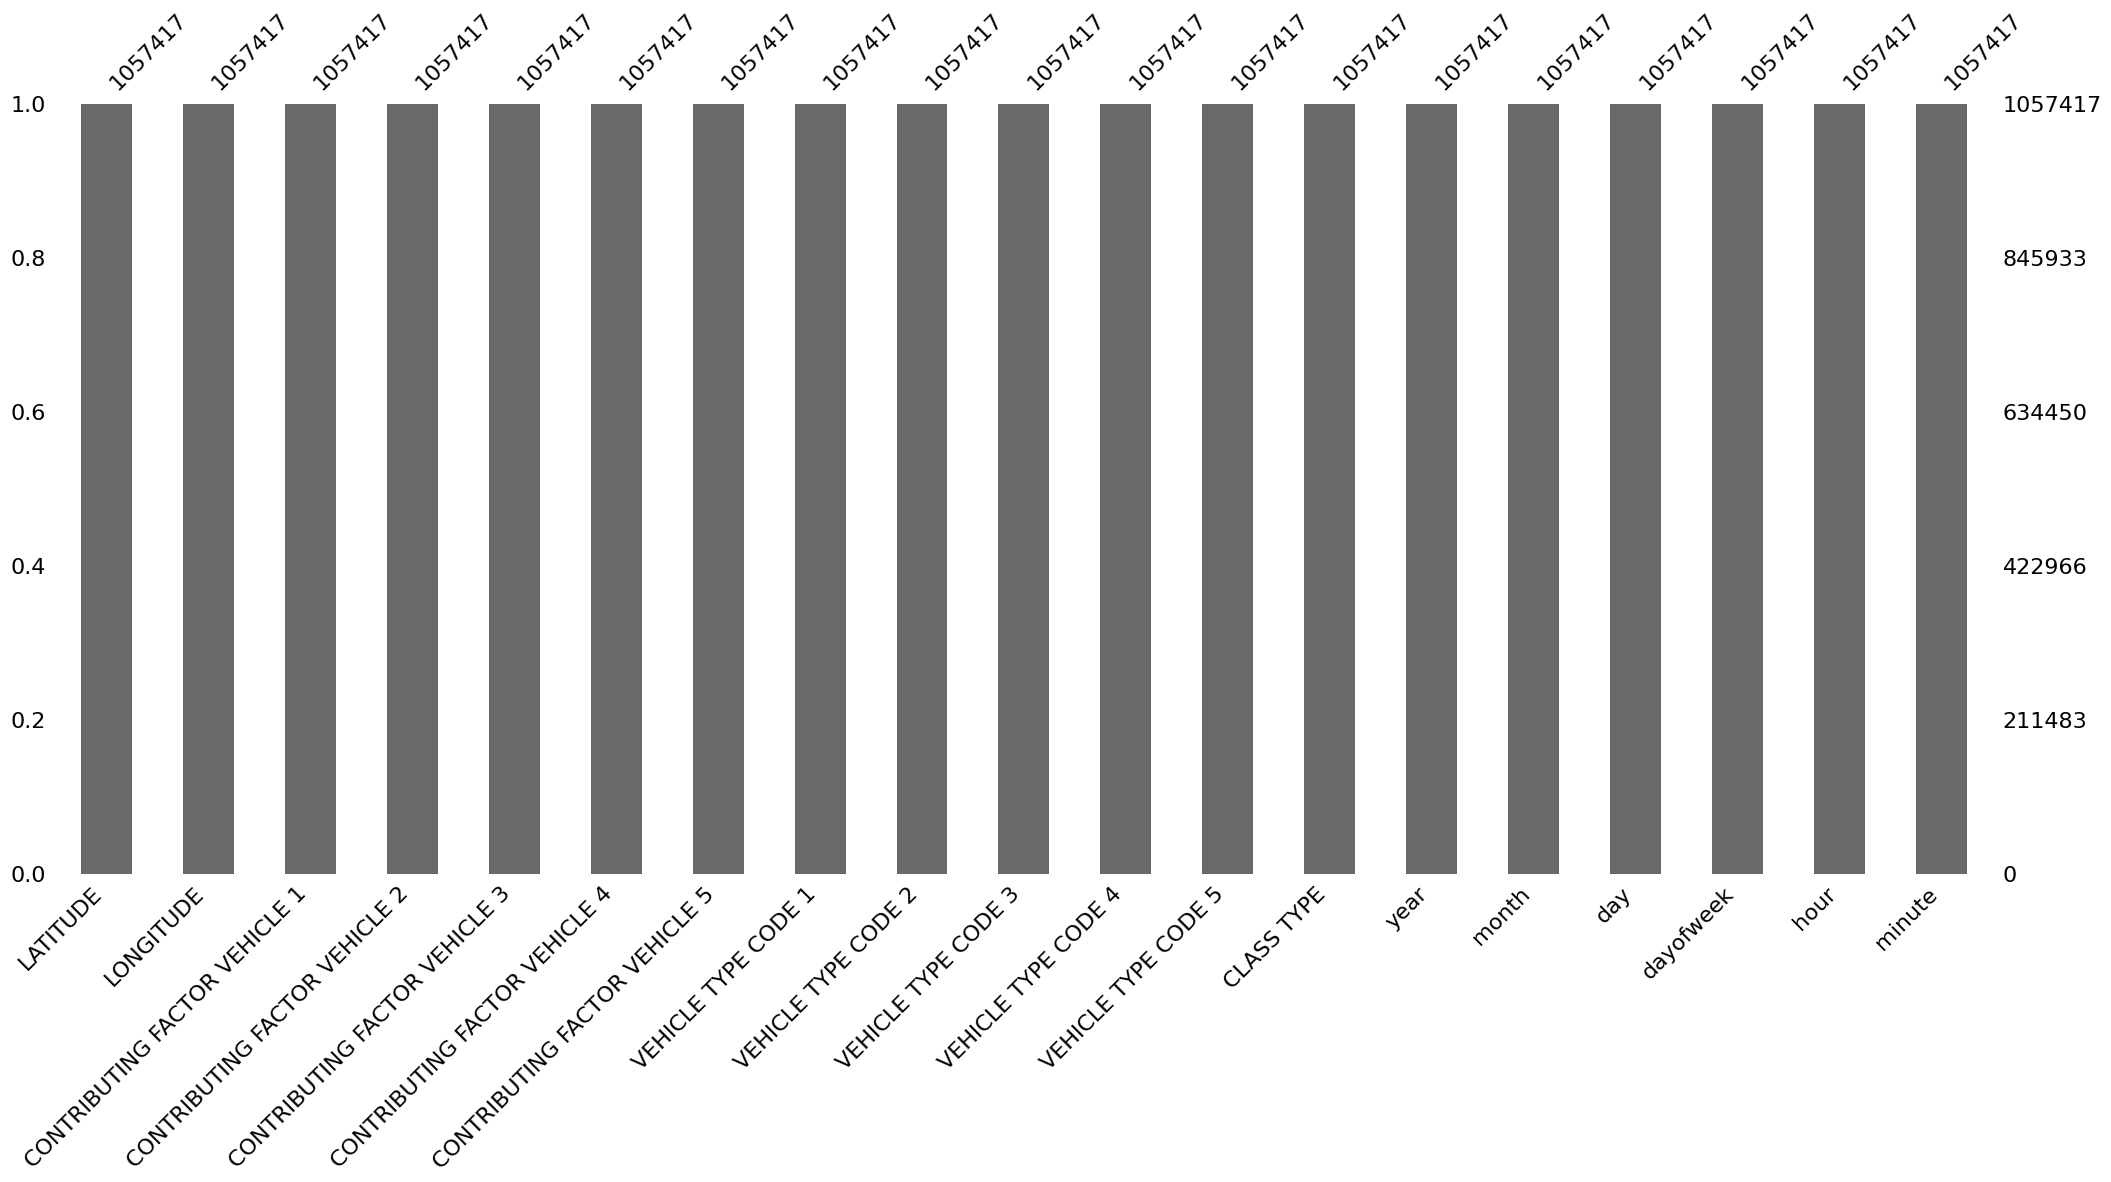

In [60]:
# Bar plot to show the completeness of the data
msno.bar(mvc_processed)


In [61]:
mvc_processed.head()

,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,year,month,day,dayofweek,hour,minute
0,40.667202,-73.866500,Unspecified,No factor,No factor,No factor,No factor,Sedan,No vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,9,11,5,9,35
1,40.868160,-73.831480,Unspecified,Unspecified,No factor,No factor,No factor,Sedan,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,14,1,8,17
2,40.751440,-73.973970,Passing Too Closely,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,14,58
3,40.675884,-73.755770,Turning Improperly,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,16,50
4,40.872620,-73.904686,Unspecified,Unspecified,No factor,No factor,No factor,Station Wagon/Sport Utility Vehicle,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,11,5,19,43


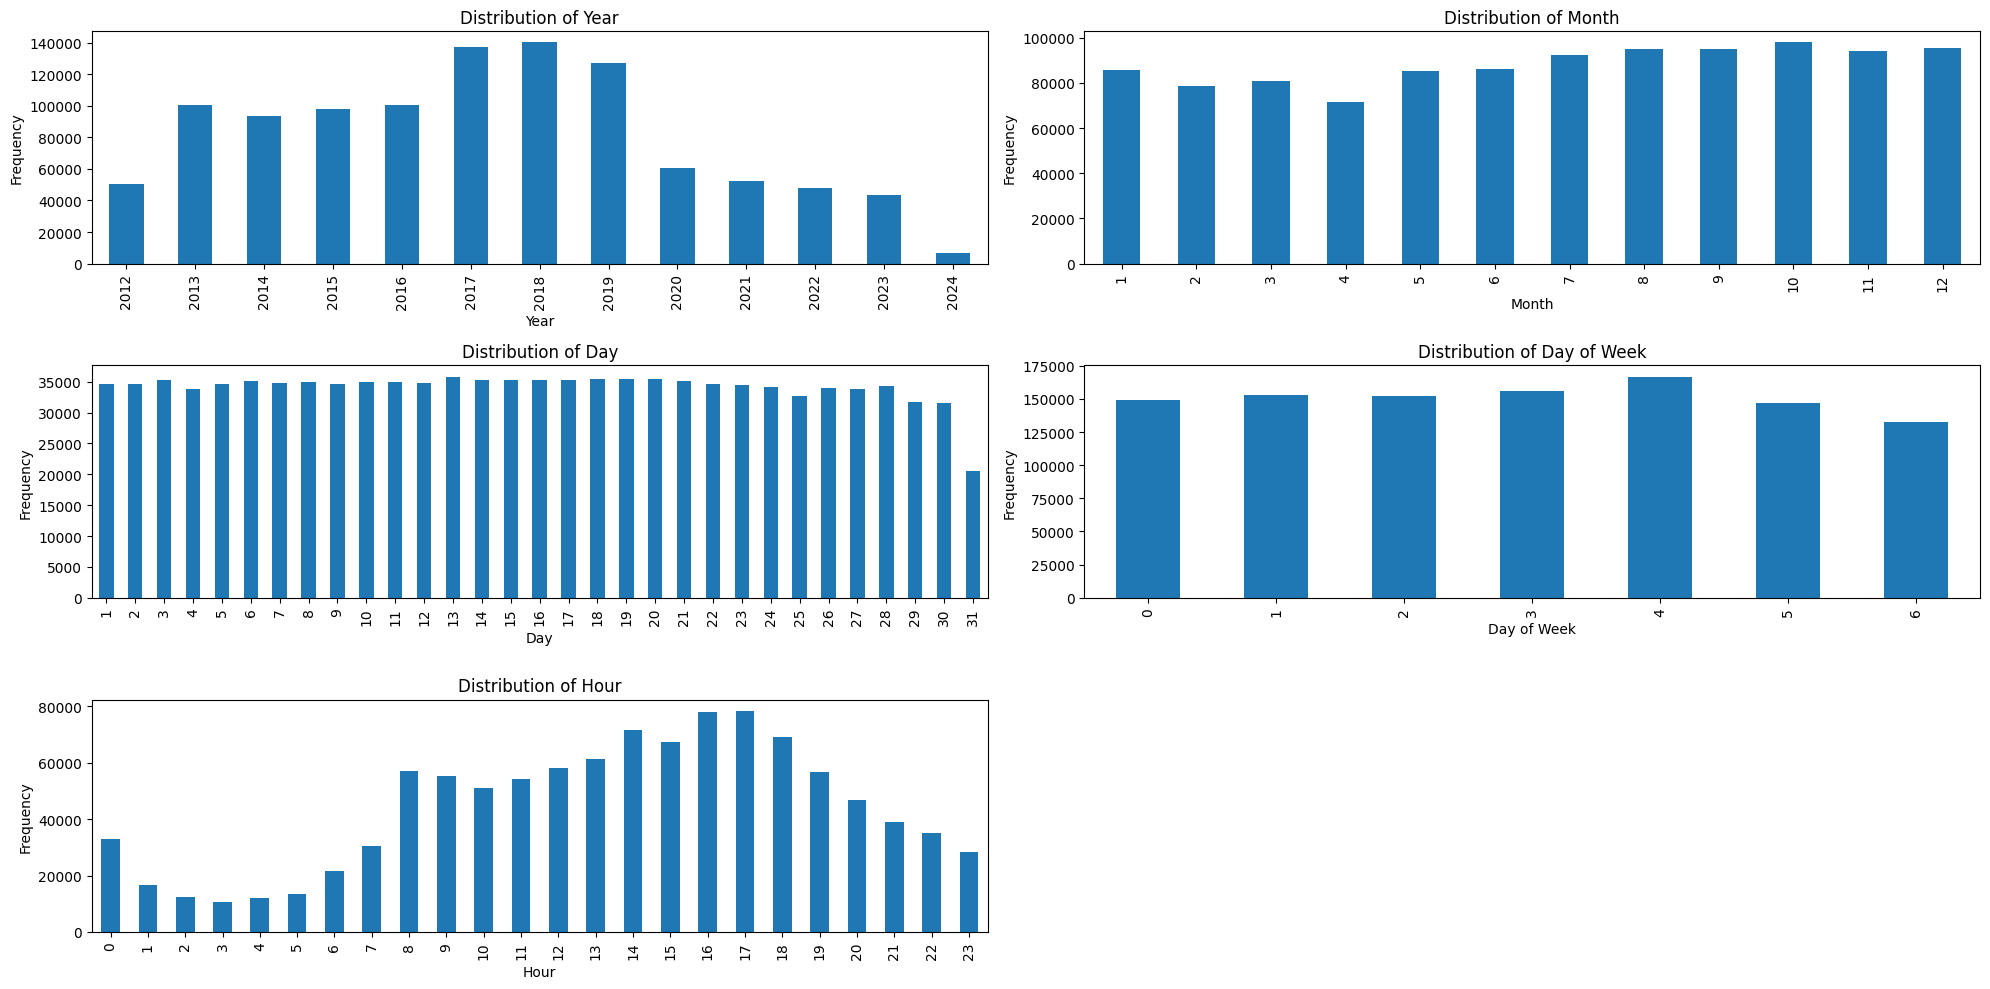

In [62]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure and size
plt.figure(figsize=(20, 10))

# Subplot 1: Year distribution
plt.subplot(3, 2, 1)
mvc_processed['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Subplot 2: Month distribution
plt.subplot(3, 2, 2)
mvc_processed['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

# Subplot 3: Day distribution
plt.subplot(3, 2, 3)
mvc_processed['day'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Day')
plt.xlabel('Day')
plt.ylabel('Frequency')

# Subplot 4: Day of Week distribution
plt.subplot(3, 2, 4)
mvc_processed['dayofweek'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

# Subplot 5: Hour distribution
plt.subplot(3, 2, 5)
mvc_processed['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()
